In [214]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
%matplotlib inline

In [215]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [257]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [367]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/jingjingxs/Desktop/2023Spring/Machine Learning/Asg2/moviereviews_train.tsv', my_random_seed=12)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


In [368]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9948, 'TN': 10052, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


In [373]:
from sklearn import linear_model
# import numpy as np
# n_samples, n_features = 10, 5
# rng = np.random.RandomState(0)
# y_train = rng.randn(n_samples)
# X_train = rng.randn(n_samples, n_features)
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
rdg = linear_model.RidgeClassifier(alpha=0.01)
rdg.fit(X_train, y_train)

rdg_performance_train1 = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train1')
rdg_performance_train1.compute_measures()
print(rdg_performance_train1.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9948, 'TN': 10052, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train1'}


In [374]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1)
rdg.fit(X_train, y_train)

rdg_performance_train2 = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train2')
rdg_performance_train2.compute_measures()
print(rdg_performance_train2.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9948, 'TN': 10052, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train2'}


In [375]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=10)
rdg.fit(X_train, y_train)

rdg_performance_train3 = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train3')
rdg_performance_train3.compute_measures()
print(rdg_performance_train3.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9948, 'TN': 10052, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train3'}


In [376]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1000)
rdg.fit(X_train, y_train)

rdg_performance_train4 = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train4')
rdg_performance_train4.compute_measures()
print(rdg_performance_train4.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9948, 'TN': 10052, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train4'}


In [377]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=6040)
rdg.fit(X_train, y_train)

rdg_performance_train5 = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train5')
rdg_performance_train5.compute_measures()
print(rdg_performance_train5.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9947, 'TN': 10052, 'FP': 0, 'FN': 1, 'Accuracy': 0.99995, 'Precision': 1.0, 'Recall': 0.9998994772818657, 'desc': 'rdg_train5'}


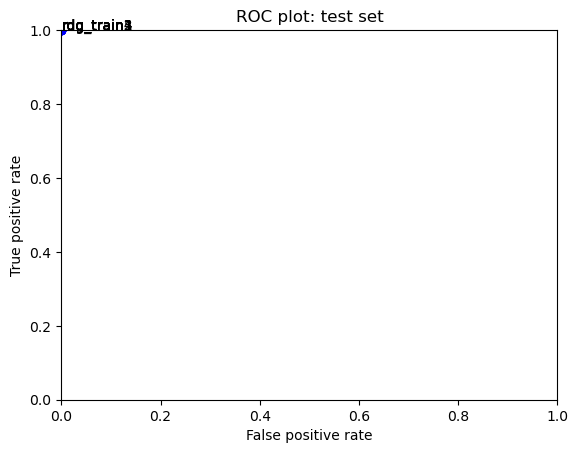

In [378]:
# ROC plot to compare performance of various models and fits
fits = [rdg_performance_train,rdg_performance_train1,rdg_performance_train2,rdg_performance_train3,rdg_performance_train4,rdg_performance_train5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [379]:
# Rdg prediction
rdg_predictions = rdg.predict(X_train)


In [380]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.5): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')

Examples of false positives:


In [381]:
# MODEL: Ridge Regression Classifier
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2220, 'TN': 2078, 'FP': 370, 'FN': 332, 'Accuracy': 0.8596, 'Precision': 0.8571428571428571, 'Recall': 0.8699059561128527, 'desc': 'rdg_test'}


In [382]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=0.01)
rdg.fit(X_train, y_train)

rdg_performance_test1 = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test1')
rdg_performance_test1.compute_measures()
print(rdg_performance_test1.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2092, 'TN': 1950, 'FP': 498, 'FN': 460, 'Accuracy': 0.8084, 'Precision': 0.8077220077220078, 'Recall': 0.8197492163009404, 'desc': 'rdg_test1'}


In [383]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1)
rdg.fit(X_train, y_train)
rdg_performance_test2 = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test2')
rdg_performance_test2.compute_measures()
print(rdg_performance_test2.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2094, 'TN': 1950, 'FP': 498, 'FN': 458, 'Accuracy': 0.8088, 'Precision': 0.8078703703703703, 'Recall': 0.8205329153605015, 'desc': 'rdg_test2'}


In [384]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=10)
rdg.fit(X_train, y_train)

rdg_performance_test3 = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test3')
rdg_performance_test3.compute_measures()
print(rdg_performance_test3.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2094, 'TN': 1951, 'FP': 497, 'FN': 458, 'Accuracy': 0.809, 'Precision': 0.8081821690467001, 'Recall': 0.8205329153605015, 'desc': 'rdg_test3'}


In [385]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1000)
rdg.fit(X_train, y_train)

rdg_performance_test4 = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test4')
rdg_performance_test4.compute_measures()
print(rdg_performance_test4.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2142, 'TN': 1992, 'FP': 456, 'FN': 410, 'Accuracy': 0.8268, 'Precision': 0.8244803695150116, 'Recall': 0.8393416927899686, 'desc': 'rdg_test4'}


In [386]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=6040)
rdg.fit(X_train, y_train)

rdg_performance_test5 = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test5')
rdg_performance_test5.compute_measures()
print(rdg_performance_test5.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2220, 'TN': 2078, 'FP': 370, 'FN': 332, 'Accuracy': 0.8596, 'Precision': 0.8571428571428571, 'Recall': 0.8699059561128527, 'desc': 'rdg_test5'}


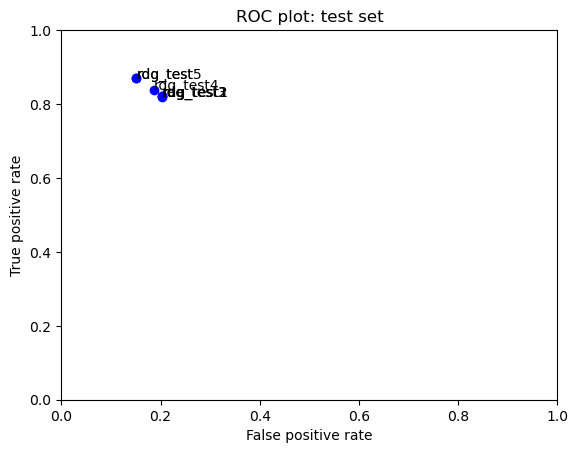

In [387]:
fits = [rdg_performance_test,rdg_performance_test1,rdg_performance_test2,rdg_performance_test3,rdg_performance_test4,rdg_performance_test5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [388]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/jingjingxs/Desktop/2023Spring/Machine Learning/Asg2/moviereviews_test.tsv', my_random_seed=12, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

In [389]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48388


In [390]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [391]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [392]:
my_submission.shape

(25000, 2)

In [393]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/jingjingxs/Desktop/2023Spring/Machine Learning/Asg2/moviereviews_submission.csv', index=False)